<a href="https://colab.research.google.com/github/DrBlizzzz/Autoencoder/blob/main/Autoencoder_alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import torch

import seaborn as sns
import matplotlib.pyplot as plt


In [32]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Danmini_Doorbell_new.csv')
data = data.sample(frac=1).reset_index(drop=True)

labels = data['Label']
del data['Label']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

# здесь фильтруем трейн
# Train = X_train.join([y_train])
X_train['Label'] = y_train
Train = X_train
Normal_X_train = Train[Train['Label'] == 0]
del Normal_X_train['Label']
del X_train['Label']  

# здесь фильтруем валидацию
# Validation = X_valid.join([y_valid])
X_valid['Label'] = y_valid
Validation = X_valid
Normal_X_valid = Validation[Validation['Label'] == 0]
del Normal_X_valid['Label']
del X_valid['Label']


In [33]:
class AutoEncoder(torch.nn.Module):

    def __init__(self, input_dense, latent_size):

        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dense, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, latent_size),
            torch.nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, input_dense),
        )

    def forward(self, x):

        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [34]:
latent_size = 10
input_dense = Normal_X_train.shape[1]

model = AutoEncoder(input_dense, latent_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('You are using:', device)
model.to(device)

loss_function = torch.nn.MSELoss()

# взял из статьи гиперпараметры
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

You are using: cpu


In [35]:
# взял из статьи гиперпараметры
epochs = 100
batch_size = 512

# тензоры для нормальных сэмплов трейна
tensor_Normal_X_train = torch.tensor(np.array(Normal_X_train))
tensor_normal_train = TensorDataset(tensor_Normal_X_train)
train_loader = DataLoader(tensor_normal_train, batch_size, shuffle=False)

# тензоры для полной валидации
tensor_X_valid = torch.tensor(np.array(X_valid))
tensor_y_valid = torch.tensor(np.array(y_valid))
tensor_validation = TensorDataset(tensor_X_valid, tensor_y_valid)
validation_loader = DataLoader(tensor_validation, batch_size, shuffle=False)

# тензоры для валидации нормальных сэмплов
tensor_Normal_X_valid = torch.tensor(np.array(Normal_X_valid))
tensor_normal_validation = TensorDataset(tensor_Normal_X_valid)
normal_validation_loader = DataLoader(tensor_normal_validation, 1, shuffle=False)

# тензоры для тестирования сэмплов
tensor_X_test = torch.tensor(np.array(X_test))
tensor_y_test = torch.tensor(np.array(y_test))
tensor_test = TensorDataset(tensor_X_test)
test_loader = DataLoader(tensor_test, 1, shuffle=False)

cached_loss = 0
counter = 0

for epoch in range(epochs):

  print('Now is', epoch)

  # тренируемся только на нормальных сэмплах
  for sample in train_loader:

    optimizer.zero_grad()

    cuda_sample = sample[0].to(device).float()

    reconstructed = torch.FloatTensor().to(device)
    reconstructed = model(cuda_sample)

    loss = loss_function(reconstructed, cuda_sample)

    loss.backward()

    optimizer.step()

  sum_loss = 0

  # здесь только проверка данных на валидации
  # мы не обучаем модель на валидации иначе она подстроится 
  for sample in validation_loader:

    cuda_sample0 = sample[0].to(device).float()

    reconstructed = torch.FloatTensor().to(device)
    reconstructed = model(cuda_sample0)

    loss = loss_function(reconstructed, cuda_sample0)

    sum_loss += loss.item()

  print(sum_loss)

  # early-stopping

  if epoch == 0:

    cached_loss = sum_loss

    counter = 0

  else:

    if cached_loss < sum_loss:

      counter += 1

      if counter == 10:

        break

    else:
      
      cached_loss = sum_loss

      counter = 0

  print(cached_loss)

  

print('End of learning')

normal_validation_losses = np.array([])

for sample in normal_validation_loader:

  cuda_sample0 = sample[0].to(device).float()

  reconstructed = torch.FloatTensor().to(device)
  reconstructed = model(cuda_sample0)

  loss = loss_function(reconstructed, cuda_sample0)

  normal_validation_losses = np.append(normal_validation_losses, loss.item())

mean = normal_validation_losses.mean()
variance = normal_validation_losses.var()

print(mean, variance)

validation_loader = DataLoader(tensor_validation, 1, shuffle=False)

validation_losses = np.array([])

for sample in validation_loader:

    optimizer.zero_grad()

    cuda_sample0 = sample[0].to(device).float()

    reconstructed = torch.FloatTensor().to(device)
    reconstructed = model(cuda_sample0)

    loss = loss_function(reconstructed, cuda_sample0)
  
    validation_losses = np.append(validation_losses, (loss.item() - mean) / (variance ** (0.5) ) )

scores = list()

sorted_dimension = list(zip(validation_losses, y_valid))
sorted_dimension.sort()

for threshold in np.linspace(-4, 4, 800):

  answers = list()
  true_answers = list()

  for pair in sorted_dimension:

    if pair[0] < threshold:

      answers.append(0)

      true_answers.append(pair[1])

    else:

      answers.append(1)

      true_answers.append(pair[1])
  
  tn, fp, fn, tp = confusion_matrix(true_answers, answers).ravel()

  positive_precision = tp / (tp + fp)
  positive_recall = tp / (tp + fn)
  positive_f1_score = (positive_precision * positive_recall) / (positive_precision + positive_recall)

  negative_precision = tn / (tn + fn)
  negative_recall = tn / (tn + fp)
  negative_f1_score = (negative_precision * negative_recall) / (negative_precision + negative_recall)

  scores.append( (threshold, positive_f1_score, negative_f1_score) )

print(scores)

# здесь ищем THRESHOLD
max_point = (0, 0, 0)

for score in scores:

  if sum(score[1:]) > sum(max_point[1:]):

    max_point = score

THRESHOLD = max_point[0]

results = list()

for test_sample in test_loader:

  cuda_sample0 = test_sample[0].to(device).float()

  reconstructed = torch.FloatTensor().to(device)
  reconstructed = model(cuda_sample0)

  loss = loss_function(reconstructed, cuda_sample0)

  if ((loss.item() - mean) / (variance ** (0.5))) <  THRESHOLD:

    results.append(0)

  else:

    results.append(1)

print(classification_report(list(y_test), results))

tn, fp, fn, tp = confusion_matrix(list(y_test), results).ravel()

print((tn, fp, fn, tp))

Now is 0
22.727786995470524
22.727786995470524
Now is 1
21.18378884345293
21.18378884345293
Now is 2
19.704210750758648
19.704210750758648
Now is 3
17.818019717931747
17.818019717931747
Now is 4
15.856353998184204
15.856353998184204
Now is 5
15.557875737547874
15.557875737547874
Now is 6
15.68192856758833
15.557875737547874
Now is 7
15.671239167451859
15.557875737547874
Now is 8
15.599351540207863
15.557875737547874
Now is 9
15.521821141242981
15.521821141242981
Now is 10
15.447230480611324
15.447230480611324
Now is 11
15.380779772996902
15.380779772996902
Now is 12
15.325302310287952
15.325302310287952
Now is 13
15.282148323953152
15.282148323953152
Now is 14
15.250608339905739
15.250608339905739
Now is 15
15.229181908071041
15.229181908071041
Now is 16
15.215185791254044
15.215185791254044
Now is 17
15.20675578713417
15.20675578713417
Now is 18
15.201837748289108
15.201837748289108
Now is 19
15.199187941849232
15.199187941849232
Now is 20
15.197776459157467
15.197776459157467
Now is 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in long_scalars
/usr/loc

[(-4.0, 0.4876426429448346, nan), (-3.9899874843554444, 0.4876426429448346, nan), (-3.9799749687108887, 0.4876426429448346, nan), (-3.969962453066333, 0.4876426429448346, nan), (-3.959949937421777, 0.4876426429448346, nan), (-3.9499374217772214, 0.4876426429448346, nan), (-3.9399249061326658, 0.4876426429448346, nan), (-3.92991239048811, 0.4876426429448346, nan), (-3.9198998748435545, 0.4876426429448346, nan), (-3.909887359198999, 0.4876426429448346, nan), (-3.8998748435544432, 0.4876426429448346, nan), (-3.889862327909887, 0.4876426429448346, nan), (-3.8798498122653315, 0.4876426429448346, nan), (-3.869837296620776, 0.4876426429448346, nan), (-3.8598247809762203, 0.4876426429448346, nan), (-3.8498122653316647, 0.4876426429448346, nan), (-3.839799749687109, 0.4876426429448346, nan), (-3.8297872340425534, 0.4876426429448346, nan), (-3.8197747183979973, 0.4876426429448346, nan), (-3.8097622027534417, 0.4876426429448346, nan), (-3.799749687108886, 0.4876426429448346, nan), (-3.78973717146

86306


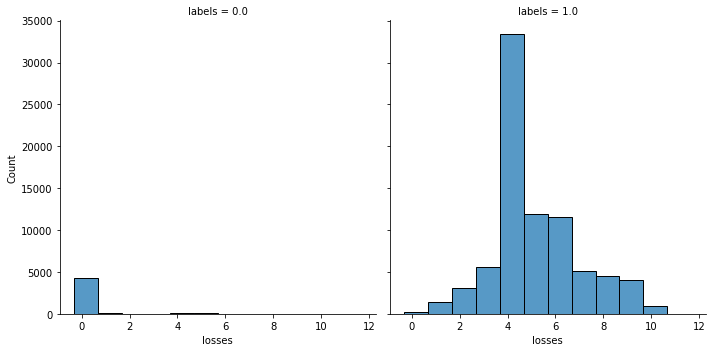

In [ ]:
losses_df = pd.DataFrame()

z_scores = list()
labels = list()

for pair in sorted_dimension:

  z_scores.append(pair[0])
  labels.append(pair[1])

losses_df['losses'] = z_scores
losses_df['labels'] = labels

print(len(losses_df))

sns.displot(x='losses', col='labels', binwidth=1 ,data=losses_df)


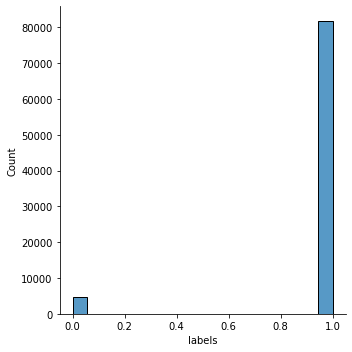

In [ ]:
df = pd.DataFrame()
df['labels'] = labels

sns.displot(x='labels',data=df)